In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import statsmodels.api as sm

In [25]:
# Set random seed for reproducibility
np.random.seed(42)

1. Data Simulation
-------------------

Assume we have data for different price points and corresponding sales.
We'll simulate this data based on a hypothetical demand curve.
This script/notebook is designed to be good structure, but just a simulation of the data, 
and not real data from an actual business

In [26]:
# Define price points
prices = np.arange(100, 501, 50)  # Prices from $100 to $500 in $50 increments

# We are going to assume a base demand at the lowest price
base_demand = 1000

# Define price elasticity of demand (negative value)
price_elasticity = -1.5  # Indicates that demand decreases as price increases

# Simulate demand based on price elasticity
# Demand = base_demand * (price / base_price) ^ elasticity
base_price = 100
demand = base_demand * (prices / base_price) ** price_elasticity

# Add some random noise to demand
noise = np.random.normal(0, 50, size=prices.shape)
demand = demand + noise
demand = np.maximum(demand, 0)  # Ensure demand isn't negative

#lastly, define cost per unit
cost_per_unit = 200  # Example cost

In [27]:
#now let's create a dataframe
data = pd.DataFrame({
    'Price': prices,
    'Demand': demand
})

print("Simulated Data:")
print(data)

Simulated Data:
   Price       Demand
0    100  1024.835708
1    150   537.417839
2    200   385.937817
3    250   329.133706
4    300   180.742421
5    350   141.013862
6    400   203.960641
7    450   143.128297
8    500    65.969000


2. Exploratory Data Analysis (EDA)
-----------------------------------

Now that we simulated the data(again if one has real data, implement that in the above section)

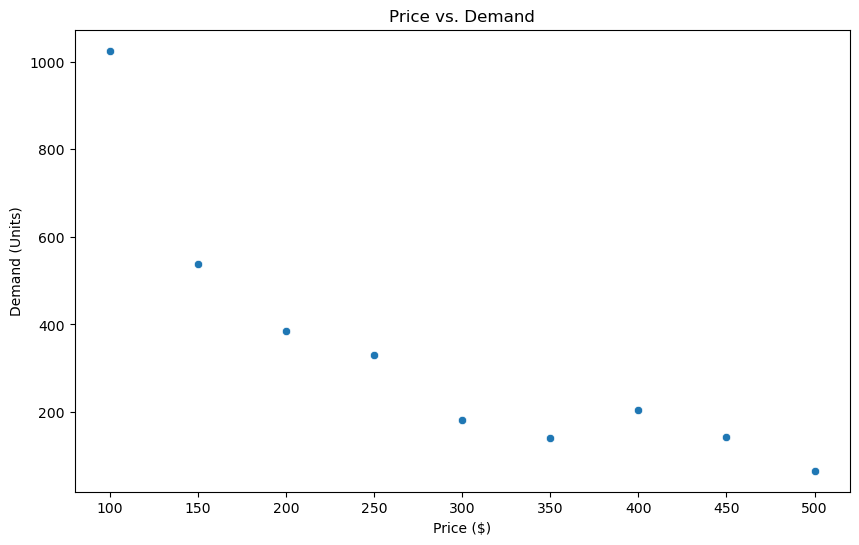

In [28]:
#let's visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Demand', data=data)
plt.title('Price vs. Demand')
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.show()

3. Demand Estimation
 ---------------------

 To estimate the relationship between price and demand, we'll use linear regression
 However, since the relationship is non-linear (power law), we'll transform it. 
 This transformation can be done multiple ways,  but we can use log.

In [29]:
# Take logarithms to linearize the power relationship
data['Log_Price'] = np.log(data['Price'])
data['Log_Demand'] = np.log(data['Demand'])

# Add a constant term for the intercept
X = sm.add_constant(data['Log_Price'])
y = data['Log_Demand']

# Fit the regression model
model = sm.OLS(y, X).fit()
print("\nDemand Estimation Model Summary:")
print(model.summary())

# Extract elasticity from the model
elasticity = model.params['Log_Price']
print(f"\nEstimated Price Elasticity of Demand: {elasticity:.2f}")


Demand Estimation Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Log_Demand   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     75.55
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           5.35e-05
Time:                        09:16:59   Log-Likelihood:                0.63228
No. Observations:                   9   AIC:                             2.735
Df Residuals:                       7   BIC:                             3.130
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7

/Users/zach/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


4. Profit Calculation
----------------------

Here we can do a simple profit calculation based on the price minus the cost, multiplied by the demand. This does not include other types of cost to the business, but simply the cost per unit.


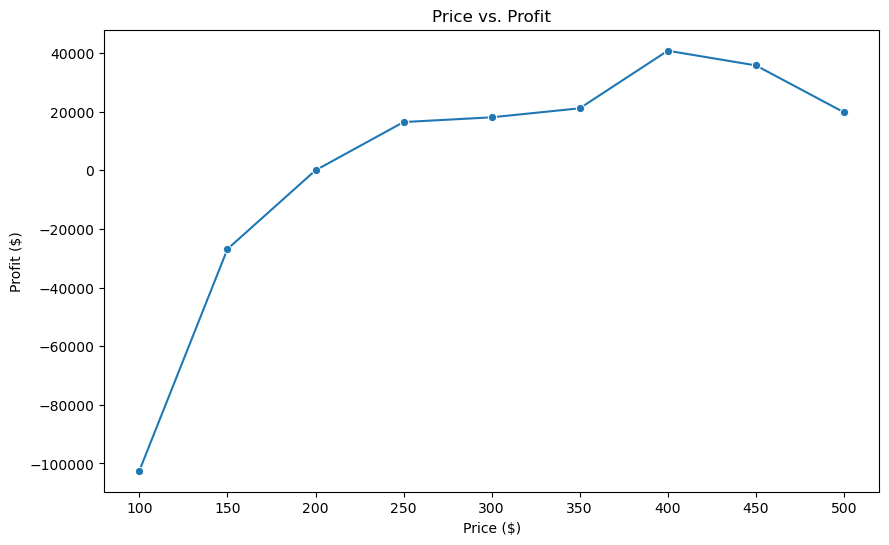

In [30]:
# Profit = (Price - Cost) * Demand
data['Profit'] = (data['Price'] - cost_per_unit) * data['Demand']

plt.figure(figsize=(10, 6))
sns.lineplot(x='Price', y='Profit', data=data, marker='o')
plt.title('Price vs. Profit')
plt.xlabel('Price ($)')
plt.ylabel('Profit ($)')
plt.show()

5. Optimization to Find Optimal Price
--------------------------------------

Now we can create a function that can find the optimal price.

In [31]:
def profit_function(price, cost, elasticity, base_price, base_demand):
    """
    Calculate profit for a given price.
    
    Parameters:
    - price: The price at which the product is sold.
    - cost: The cost per unit.
    - elasticity: Price elasticity of demand.
    - base_price: Reference price.
    - base_demand: Demand at the reference price.
    
    Returns:
    - Negative profit (since we will minimize this function)
    """
    demand = base_demand * (price / base_price) ** elasticity
    profit = (price - cost) * demand
    return -profit  # Negative because we use a minimizer in a later step

In [32]:
# Initial guess for the price
initial_price = 300

# Define bounds for the price (e.g., between $100 and $500)
bounds = [(100, 500)]

# Perform the optimization
result = minimize(
    profit_function,
    x0=[initial_price],
    args=(cost_per_unit, elasticity, base_price, base_demand),
    bounds=bounds,
    method='L-BFGS-B'
)

optimal_price = result.x[0]
max_profit = -result.fun

print(f"\nOptimal Price: ${optimal_price:.2f}")
print(f"Expected Maximum Profit: ${max_profit:.2f}")


Optimal Price: $500.00
Expected Maximum Profit: $28365.35


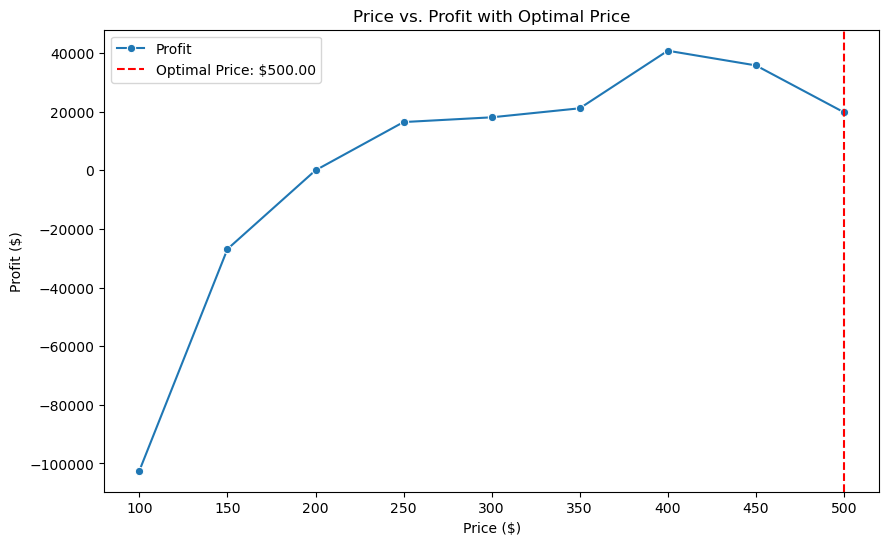

In [33]:
# Plotting the profit curve with the optimal price
plt.figure(figsize=(10, 6))
sns.lineplot(x='Price', y='Profit', data=data, marker='o', label='Profit')
plt.axvline(x=optimal_price, color='red', linestyle='--', label=f'Optimal Price: ${optimal_price:.2f}')
plt.title('Price vs. Profit with Optimal Price')
plt.xlabel('Price ($)')
plt.ylabel('Profit ($)')
plt.legend()
plt.show()

6. Conclusion
-------------

The analysis indicates that the optimal price for maximizing profit is 500.
At this price point, the expected profit is approximately $28365.35.


**Assumptions & Considerations:**
- The demand curve follows a power-law relationship with price. This isn't always so cut and dry.
- Fixed cost per unit is $200. 
- External factors such as competition, market conditions, and production capacity are not considered. Sometimes it might be better to start off at a slight loss or less profit if it can enable an entrance into the market or increase the demand
- Real-world data would provide a more accurate demand estimation. This is just a simulation to break down how to go about calculating an optimal pricing strategy. 
- Cost Structure Analysis can allow to incorporate variable and fixed costs more accurately. If one were to have real world data, make sure to add in the cost structure analysis.
- With aditional real world data, also add in additional factoring using multiple regression or machine learning.  
- One should also taking into account how changes in external factors (e.g., policy changes, economic shifts) impact the optimal pricing strategy. 